# Model Training

In [1]:
import MIMENetEnsemble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

In [2]:
#set training parameters
training_path = "../data/experimental_data/training_data/training.txt"
model_path = "./experimental_model/experimental_model"
epochs = 15
learning_rate = 0.00001
batch_size = 2**13
lambda_l2 = 0.00001
hidden_size_factor = 2
bottleneck = 1/2
backup_interval = 1

In [3]:
model, history = MIMENetEnsemble.train(
    training_path=training_path,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_l2=lambda_l2,
    hidden_size_factor=hidden_size_factor,
    bottleneck=bottleneck,
    model_path=model_path,
    backup_interval=backup_interval
)

Device: cuda:0
Number of training examples: 18544275
Loaded model from ./experimental_model/experimental_model.pt
Loaded optimizer from ./experimental_model/experimental_model_optimizer.pt


Epoch: 15/15: 100%|██████████| 2264/2264 [1:18:03<00:00,  2.07s/it]


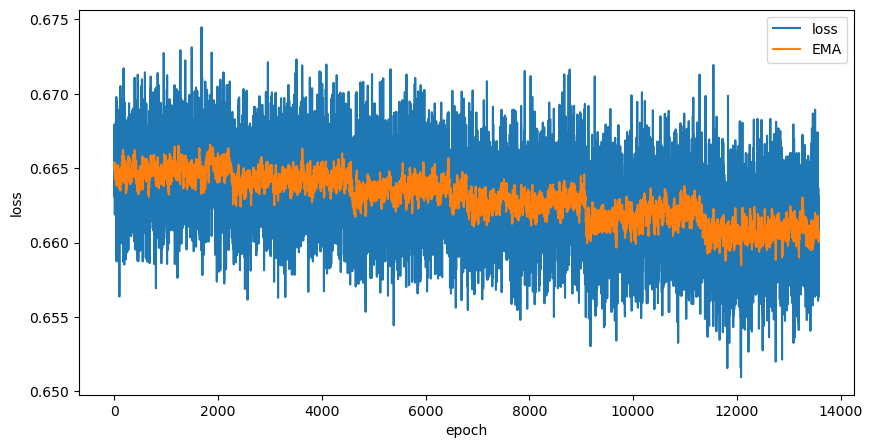

In [16]:
# load training history
train_history = np.loadtxt("./experimental_model/experimental_model_train_history.txt")

# plot training history
# set fig size
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_history)), train_history)
# also plot exponential moving average
ema = []
ema.append(train_history[0])
for i in range(1, len(train_history)):
    ema.append(0.9*ema[i-1]+0.1*train_history[i])
plt.plot(range(len(ema)), ema)
plt.legend(["loss", "EMA"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [17]:
# load prediction history
prediction_history = np.loadtxt("./experimental_model/experimental_model_prediction_history.txt")
print(prediction_history.shape)
prediction_history[0]

(16, 2142)


array([0.47794105, 0.47179389, 0.49650759, ..., 0.49660603, 0.49640761,
       0.49618534])

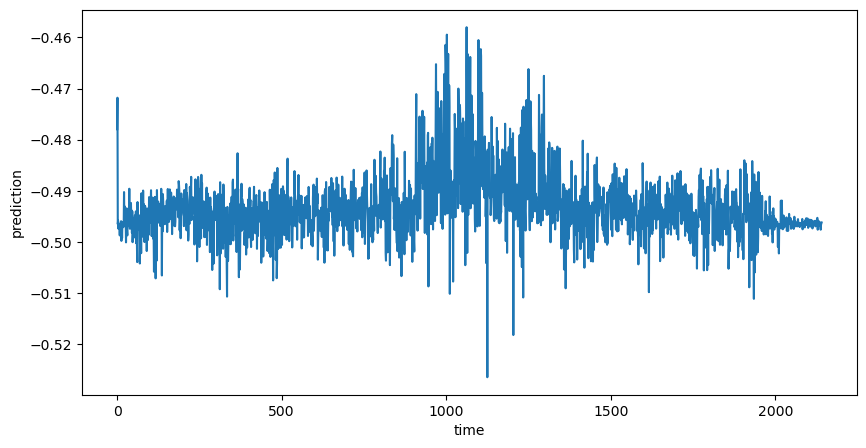

In [19]:
# line plot of last row of prediction history
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[0])), -1*prediction_history[0])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

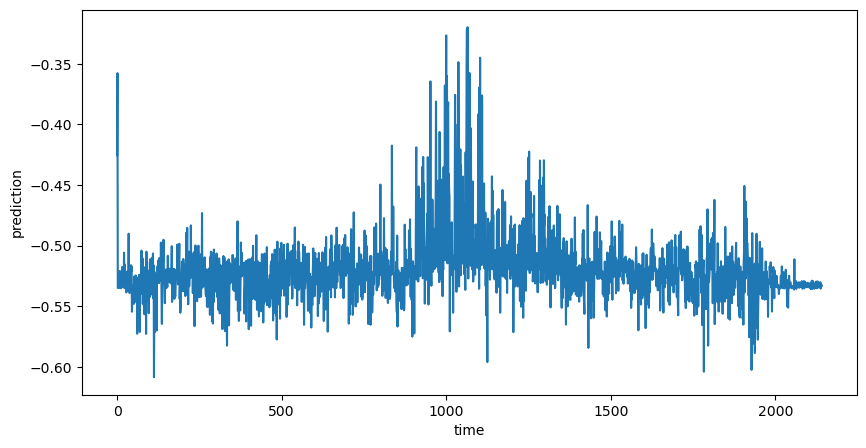

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(prediction_history[-1])), -1*prediction_history[-1])
plt.xlabel("time")
plt.ylabel("prediction")
plt.show()

In [4]:
#save training history as json
with open('./experimental_model/history_exp_model.json', 'w') as f:
    json.dump(history, f)

In [5]:
#load history
with open('./experimental_model/history_exp_model.json', 'r') as f:
    history = json.load(f)

In [11]:
# save final model
torch.save(model.state_dict(), './experimental_model/final_model.pt')

In [14]:
#load final model
input_size = len(open(training_path).readline().split('_')[0])
model = MIMENetEnsemble.MIMENetEnsemble(input_size=input_size, hidden_size_factor=hidden_size_factor, bottleneck=bottleneck, output_size=1)
model.load_state_dict(torch.load('./experimental_model/final_model.pt'))
model.to('cuda')

MIMENetEnsemble(
  (fc1): Linear(in_features=2148, out_features=4296, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=4296, out_features=4296, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=4296, out_features=4296, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=4296, out_features=2148, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=2148, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Text(0, 0.5, 'Avg Difference')

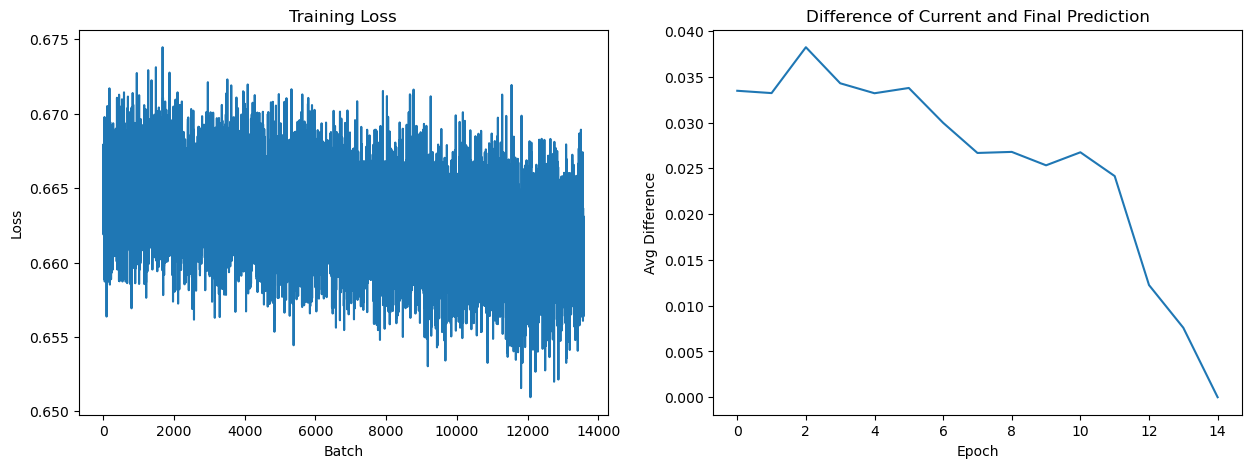

In [15]:
# set up 3 side by side plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

#plot training history
axs[0].plot(history['training'])
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

#plot difference of current and final prediction

#initialize difference array
predictions = np.array(history['prediction'][1:])
difference = np.zeros((predictions.shape[0], predictions.shape[1]))
#calculate difference
for i in range(predictions.shape[0]):
    difference[i] = np.abs(predictions[i] - predictions[-1])
#average over columns
difference = np.mean(difference, axis=1)
#plot difference
axs[1].plot(difference)
axs[1].set_title('Difference of Current and Final Prediction')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Avg Difference')

In [23]:
path_wildtype = "../data/experimental_data/5NL43.txt"

In [24]:
with open(path_wildtype, 'r') as f:
        wildtype = f.read()
        
print(wildtype)

GGTCTCTCTGGTTAGACCAGATCTGAGCCTGGGAGCTCTCTGGCTAACTAGGGAACCCACTGCTTAAGCCTCAATAAAGCTTGCCTTGAGTGCTCAAAGTAGTGTGTGCCCGTCTGTTGTGTGACTCTGGTAACTAGAGATCCCTCAGACCCTTTTAGTCAGTGTGGAAAATCTCTAGCAGTGGCGCCCGAACAGGGACTTGAAAGCGAAAGTAAAGCCAGAGGAGATCTCTCGACGCAGGACTCGGCTTGCTGAAGCGCGCACGGCAAGAGGCGAGGGGCGGCGACTGGTGAGTACGCCAAAAATTTTGACTAGCGGAGGCTAGAAGGAGAGAGATGGGTGCGAGAGCGTCGGTATTAAGCGGGGGAGAATTAGATAAATGGGAAAAAATTCGGTTAAGGCCAGGGGGAAAGAAACAATATAAACTAAAACATATAGTATGGGCAAGCAGGGAGCTAGAACGATTCGCAGTTAATCCTGGCCTTTTAGAGACATCAGAAGGCTGTAGACAAATACTGGGACAGCTACAACCATC


In [48]:
def inferSingleKds(model, n_protein_concentrations, n_rounds, path_wildtype, n : int):

    # read in wildtype
    with open(path_wildtype, 'r') as f:
        wildtype = f.read()

    n_features = len(wildtype) * 4 + n_protein_concentrations * n_rounds
    
    kds_nucleotide = []
    kds_position = []
    prediction_example = np.zeros(n_features)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for pos, feature in enumerate(tqdm(range(n_protein_concentrations*n_rounds, n_features, 4))):
        
        prediction_example_wildtype = prediction_example.copy()
        prediction_example_mut1 = prediction_example.copy()
        prediction_example_mut2 = prediction_example.copy()
        prediction_example_mut3 = prediction_example.copy()

        # get wildtype at position
        wildtype_nucleotide = wildtype[pos]

        order_nucleotides = ['A', 'C', 'G', 'T']

        # get index of wildtype nucleotide
        index_wildtype = order_nucleotides.index(wildtype_nucleotide)

        # set wildtype nucleotide
        prediction_example_wildtype[feature + index_wildtype] = 1

        # set mutant nucleotides
        indices_mutants = [i for i in range(4) if i != index_wildtype]
        prediction_example_mut1[feature + indices_mutants[0]] = 1
        prediction_example_mut2[feature + indices_mutants[1]] = 1
        prediction_example_mut3[feature + indices_mutants[2]] = 1


        # convert all to tensors
        prediction_example_wildtype = torch.tensor(prediction_example_wildtype, dtype=torch.float32).to(device)
        prediction_example_mut1 = torch.tensor(prediction_example_mut1, dtype=torch.float32).to(device)
        prediction_example_mut2 = torch.tensor(prediction_example_mut2, dtype=torch.float32).to(device)
        prediction_example_mut3 = torch.tensor(prediction_example_mut3, dtype=torch.float32).to(device)

        # predict
        with torch.no_grad():
            wildtype_prediction = model.predict(prediction_example_wildtype, n)
            mut1_prediction = model.predict(prediction_example_mut1, n)
            mut2_prediction = model.predict(prediction_example_mut2, n)
            mut3_prediction = model.predict(prediction_example_mut3, n)

            # calculate kd
            wildtype_kd = 1 / np.array(wildtype_prediction) - 1
            mut1_kd = 1 / np.array(mut1_prediction) - 1
            mut2_kd = 1 / np.array(mut2_prediction) - 1
            mut3_kd = 1 / np.array(mut3_prediction) - 1

            # correct kds
            mut1_kd_rel = mut1_kd / wildtype_kd
            mut2_kd_rel = mut2_kd / wildtype_kd
            mut3_kd_rel = mut3_kd / wildtype_kd

            # average kds over the 3 mutations
            pos_kd = np.mean([mut1_kd_rel, mut2_kd_rel, mut3_kd_rel], axis=0)
            
            # append to lists
            kds_nucleotide.append(mut1_kd_rel.tolist())
            kds_nucleotide.append(mut2_kd_rel.tolist())
            kds_nucleotide.append(mut3_kd_rel.tolist())
            kds_position.append(pos_kd.tolist())

    return kds_nucleotide, kds_position

In [49]:
kds_nucleotide, kds_position = inferSingleKds(model, 4, 2, path_wildtype, 100)

100%|██████████| 535/535 [03:02<00:00,  2.93it/s]


In [50]:
kds_nucleotide = np.array(kds_nucleotide)
kds_position = np.array(kds_position)

print(kds_nucleotide.shape)
print(kds_position.shape)

(1605, 100)
(535, 100)
